<a href="https://colab.research.google.com/github/yingzibu/MOL2ADMET/blob/main/examples/experiments/RNN/ADMET_RNN_10_26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [85]:
cd /content/drive/MyDrive/ADMET

/content/drive/MyDrive/ADMET


In [ ]:
! pip install PyTDC --quiet
! pip install selfies  --quiet
! pip install pubchempy --quiet
! pip install molvs --quiet
! pip install mycolorpy --quiet

In [3]:
from tdc.generation import MolGen
import selfies as sf
from tqdm import tqdm
from torch.nn.utils.rnn import pack_sequence
from torch.utils.data import DataLoader

data = MolGen(name = 'ZINC')
split = data.get_split()
train = split['train']
valid = split['valid']
test = split['test']

len(train), len(valid), len(test)

Downloading...
100%|██████████| 11.8M/11.8M [00:02<00:00, 5.67MiB/s]
Loading...
Done!


(174618, 24946, 49891)

In [164]:
import pandas as pd
from tdc import Oracle
import matplotlib.pyplot as plt

qed = Oracle(name='QED')
sa = Oracle(name='SA')
# qed('CCC'), sa('CCC')

def get_min(d:dict):
    min_key = next(iter(d))

    # Iterate over the keys in the dictionary
    for key in d:
        # If the value of the current key > the value of max_key, update max_key
        if d[key] < d[min_key]:
            min_key = key
    return min_key, d[min_key]

def plot_loss(train_dict, test_dict, name='test', title_name=None):
    fig = plt.figure()
    plt.plot(list(train_dict.keys()), list(train_dict.values()), label='train')
    plt.plot(list(test_dict.keys()), list(test_dict.values()), label=name)
    argmin, min = get_min(test_dict)
    plt.plot(argmin, min, '*', label=f'min epoch {argmin}')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    if title_name == None: title_name = 'loss during training'
    plt.title(title_name)
    plt.legend()
    plt.show()

def convert_with_qed_sa(train):
    smi_list = train['smiles'].tolist()
    smile_list = []
    qed_list = []
    sa_list = []
    for i, smi in tqdm(enumerate(smi_list), total=len(smi_list),
                       desc='cal QED/SA, delete invalid'):
        try:
            qed_ = qed(smi)
            sa_ = sa(smi)
            smile_list.append(smi)
            qed_list.append(qed_)
            sa_list.append(sa_)
        except: pass

    df = pd.DataFrame()
    df['smiles'] = pd.DataFrame(smile_list)
    df['qed'] = pd.DataFrame(qed_list)
    df['sa'] = pd.DataFrame(sa_list)
    df = df.reset_index(drop=True)
    return df

from scripts.eval_utils import *
from scripts.preprocess_mols import *
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

device = 'cuda'
import sklearn.metrics as metrics

import numpy as np
def make_path(path_name, verbose=True):
    import os
    if os.path.exists(path_name):
        if verbose: print('path:', path_name, 'already exists')
    else: os.makedirs(path_name); print('path:', path_name, 'is created')

def reg_evaluate(label_clean, preds_clean):
    mae = metrics.mean_absolute_error(label_clean, preds_clean)
    mse = metrics.mean_squared_error(label_clean, preds_clean)
    rmse = np.sqrt(mse) #mse**(0.5)
    r2 = metrics.r2_score(label_clean, preds_clean)

    print('  MAE     MSE     RMSE    R2')
    print("&%5.3f" % (mae), " &%5.3f" % (mse), " &%5.3f" % (rmse),
      " &%5.3f" % (r2))

    eval_result_r2 =   f'R2:     {r2:.3f}'
    eval_result_mae =  f'MAE:   {mae:.3f}'
    eval_result_rmse = f'RMSE: {rmse:.3f}'

    return eval_result_r2, eval_result_mae, eval_result_rmse

from mycolorpy import colorlist as mcp
import matplotlib.pyplot as plt

def eval_dict(y_probs:dict, y_label:dict, names:list, IS_R, draw_fig=False,
              fig_title=None, fig_path=None):
    if isinstance(IS_R, list): task_list = IS_R
    else: task_list = [IS_R] * len(names)
    for i, (name, IS_R) in enumerate(zip(names, task_list)):
        # IS_R = task_list[i]
        print('*'*15, name, '*'*15)
        # print('Regression task', IS_R)

        probs = y_probs[name]
        label = y_label[name]
        assert len(probs) == len(label)
        if IS_R == False: # classification task
            preds = get_preds(0.5, probs)
            evaluate(label, preds, probs)

        else: # regression task
            r2, mae, rmse = reg_evaluate(label, probs)
            if draw_fig:
                color = mcp.gen_color_normalized(cmap='viridis',
                                                data_arr=label)
                plt.scatter(label, probs, cmap='viridis', marker='.',
                            s=10, alpha=0.5, edgecolors='none', c=color)
                plt.xlabel(f'True {name}')
                plt.ylabel(f'Predicted {name}')
                if fig_title == None: title = f'{name} prediction on test set'
                else: title = f'{name} {fig_title}'
                plt.title(title)

                x0, xmax = plt.xlim()
                y0, ymax = plt.ylim()
                data_width = xmax - x0
                data_height = ymax - y0
                # print(x0, xmax, y0, ymax, data_width, data_height)
                plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8/0.95, r2)
                plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8,  mae)
                plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8*0.95, rmse)
                make_path(fig_path, False)
                plt.savefig(f'{fig_path}/{title}.png', format='png',
                            transparent=False)
                plt.show()
                plt.cla()
                plt.clf()
                plt.close()
        print()

# TEST Classification
b = evaluate([1, 0, 1], [1, 1, 1], [1, 0.6, 1])
print(b[0])

# TEST Regression
reg_evaluate([2.3, 2.1], [3, 2])


equation for MCC is (TP*TN-FP*FN)*1.0/(math.sqrt(temp))
TP, FP, TN, FN 2 1 0 0
temp=0
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.667  &  0.500  &          0.667  &     1.000  &0.000  &0.800 &1.000 &  N/A &   1.000
0.6666666666666666
  MAE     MSE     RMSE    R2
&0.400  &0.250  &0.500  &-24.000


('R2:     -24.000', 'MAE:   0.400', 'RMSE: 0.500')

In [23]:
import torch
chars = set()
for string in train['smiles']: chars.update(string)
all_sys =  ['<pad>', '<bos>', '<eos>', '<unk>'] + sorted(list(chars))
vocab = all_sys
c2i = {c: i for i, c in enumerate(all_sys)}
i2c = {i: c for i, c in enumerate(all_sys)}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vector = torch.eye(len(c2i))

def char2id(char):
    if char not in c2i: return c2i['<unk>']
    else: return c2i[char]

def id2char(id):
    if id not in i2c: return i2c[c2i['<unk>']]
    else: return i2c[id]

def string2ids(string,add_bos=False, add_eos=False):
    ids = [char2id(c) for c in string]
    if add_bos: ids = [c2i['<bos>']] + ids
    if add_eos: ids = ids + [c2i['<eos>']]
    return ids

def ids2string(ids, rem_bos=True, rem_eos=True):
    # print(ids)
    if isinstance(ids[0], list): ids = ids[0]
    if len(ids) == 0: return ''
    if rem_bos and ids[0] == c2i['<bos>']: ids = ids[1:]
    # delete <eos>
    if rem_eos:
        for i, id in enumerate(ids):
            # print(i, id)
            if id == c2i['<eos>']: ids = ids[:i]; break

    # if rem_eos and ids[-1] == c2i['<eos>']:
    #     ids = ids[:-1]

    string = ''.join([id2char(id) for id in ids])
    return string

def string2tensor(string, device='model'):
    ids = string2ids(string, add_bos=True, add_eos=True)
    tensor = torch.tensor(ids, dtype=torch.long,
                          device=device if device == 'model' else device)
    return tensor

# tensor = [string2tensor(string, device=device) for string in train['smiles']]


vector = torch.eye(len(c2i))  # (alphabet_len, alphabet_len)

In [13]:

vector = torch.eye(len(c2i))  # (alphabet_len, alphabet_len)
vector, len(c2i), len(vocab)

(tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]]),
 35,
 38)

In [118]:
import torch
import torch.nn as nn
import torch.nn.functional as F

q_bidir = True
q_d_h = 254
q_n_layers = 3
q_dropout = 0.5


d_n_layers = 3
d_dropout = 0

d_z = 128 * 2 ############################################
d_d_h = 519

### loader params
n_batch = 514
n_workers = 0
# from data import *
num_classes = 2 # task number
device = device

class RNN(nn.Module):
    def __init__(self, vocab, vector):
        super().__init__()
        self.vocabulary = vocab
        self.vector = vector
        n_vocab, d_emb = len(vocab), vector.size(1)
        self.bidirectional = q_bidir
        self.x_emb = nn.Embedding(n_vocab, d_emb, c2i['<pad>'])
        self.x_emb.weight.data.copy_(vector)
        self.num_layers = q_n_layers
        self.dropout_num = q_dropout if q_n_layers>1 else 0
        self.q_d_h = q_d_h
        self.gru = nn.GRU(d_emb, q_d_h, num_layers = self.num_layers,
                          batch_first=True, dropout=self.dropout_num,
                          bidirectional=self.bidirectional)
        q_d_last = q_d_h * (2 if self.bidirectional else 1)
        self.hidden_size = q_d_last
        self.fc = nn.Linear(self.hidden_size, self.q_d_h)
        self.final = nn.Linear(self.q_d_h, num_classes)
        self.device = device

    def forward(self, x):
        x = [self.x_emb(i_x) for i_x in x]
        x = nn.utils.rnn.pack_sequence(x)
        _, h = self.gru(x, None)
        # print('h shape ', h.shape) #torch.Size([6, 512, 256])
        h = h[-(1 + int(self.gru.bidirectional)):]
        h = torch.cat(h.split(1), dim=-1).squeeze(0) # torch.Size([512, 512])
        h = F.relu(self.fc(h))
        return self.final(h)

    # def forward_s(self, x):
    #     len_x = x.shape[0]
    #     x = [self.x_emb(i_x) for i_x in x]

    #     x = nn.utils.rnn.pack_sequence(x)
    #     h_dim_0 = self.num_layers * (2 if self.bidirectional else 1)
    #     # h_dim_1 = self.hidden_size
    #     # h_dim_2 = self.q_d_h * (2 if self.bidirectional else 1)
    #     h0 = torch.zeros(h_dim_0, len_x, self.q_d_h).to(self.device)
    #     out, _ = self.gru(x, h0)
    #     # print('out shape here: ', out.shape)
    #     out = out[:, -1, :]
    #     print('after something: ', out.shape)
    #     out = self.fc(out)
    #     return out

# model = RNN(vocab, vector).to(device)
# model(x).shape

In [114]:
from torch.nn.utils.rnn import pack_sequence, pad_sequence
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset

class dataset(Dataset):
    def __init__(self, df, device):
        super(dataset, self).__init__()
        self.df = df
        self.device = device
        self.len = len(df)

    def __getitem__(self, idx):
        label = [self.df['qed'][idx], self.df['sa'][idx]]

        label = torch.tensor(label, dtype=torch.float32).to(self.device)

        smi = self.df['smiles'][idx]
        tensor = string2tensor(smi, device=self.device)
        # x_padded = pad_sequence(tensor, batch_first=True, padding_value=c2i[''])

        return [tensor, label]
        # tensor = [string2tensor(string)]

    def __len__(self): return self.len

def my_collate(batch):
    # batch contains a list of tuples of structure (sequence, target)
    data = [item[0] for item in batch]
    data = pad_sequence(data, batch_first=True, padding_value=c2i['<pad>'])
    # targets = [item[1] for item in batch]
    targets = [item[1] for item in batch]
    targets = torch.stack(targets)
    return (data, targets)

def gen_loader(train:pd.DataFrame):
    df = train.copy()
    loader = DataLoader(dataset(df, device=device), batch_size=n_batch,
                        shuffle=True, num_workers=n_workers,
                        collate_fn=my_collate)
    return loader

In [100]:
def scale(trains_, valids_, tests_):
    trains, valids, tests = trains_.copy(), valids_.copy(), tests_.copy()
    print('scaling train valid test data set for regression task ')
    dict_scale = {}
    for col in trains.columns:
        if col in ['Drug', 'smiles', 'smile']: pass
        else:
            # print(col)
            min_here = min(trains[col].min(), valids[col].min(), tests[col].min())
            max_here = max(trains[col].max(), valids[col].max(), tests[col].max())
            dict_scale[col] = [min_here, max_here]
            delta_here = max_here - min_here
            trains[col] = (trains[col] - min_here) / delta_here
            valids[col] = (valids[col] - min_here) / delta_here
            tests[col]  = (tests[col]  - min_here) / delta_here

    return trains, valids, tests, dict_scale
# trains = convert_with_qed_sa(train)
train_, valid_, test_ = train[:20000], valid[:2000], test[:4000]
train_, valid_, test_ = convert_with_qed_sa(train_), \
                        convert_with_qed_sa(valid_), convert_with_qed_sa(test_)
trains, valids, tests, dict_scale = scale(train_, valid_, test_)

cal QED/SA, delete invalid: 100%|██████████| 4000/4000 [00:09<00:00, 420.95it/s]

scaling train valid test data set for regression task 


In [116]:
loader = gen_loader(trains)
valid_loader = gen_loader(valids)
test_loader = gen_loader(tests)

In [165]:
import torch.optim as optim

model = RNN(vocab, vector).to(device)

criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
from tqdm import tqdm

train_dict, valid_dict = {}, {}
for epoch in range(100):
    losses = 0
    model.train()
    for x, label in loader:
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, label)
        losses += loss.item()
        loss.backward()
        optimizer.step()
    losses /= len(loader.dataset)

    losses_valid = 0
    model.eval()
    with torch.no_grad():
        for x, label in valid_loader:
            outputs = model(x)
            loss = criterion(outputs, label)
            losses_valid += loss.item()
    losses_valid /= len(valid_loader.dataset)
    train_dict[epoch], valid_dict[epoch] = losses, losses_valid
    print(f'Epoch {epoch}: LOSS [Train]: {losses:.3f} | '
          f'[Valid]: {losses_valid:.3f}')
    if epoch % 2 == 0:
        if epoch != 0: plot_loss(train_dict, valid_dict, name='valid')

        model.eval()
        probs_dict, label_dict = {}, {}
        with torch.no_grad():
            for idx, (x, labels) in enumerate(test_loader):
                output = model(x)
                # print(type(preds))
                for j, name in enumerate(['qed', 'sa']):
                    # print(j, name)
                    # print(preds[:, j])
                    # print(preds.shape)
                    preds = output[:, j].cpu().detach().numpy().tolist()
                    label = labels[:, j].cpu().detach().numpy().tolist()
                    if idx == 0:
                        probs_dict[name] = preds
                        label_dict[name] = label
                    else:
                        probs_dict[name] += preds
                        label_dict[name] += label
        for name in ['qed', 'sa']: # scale back
            min_here = dict_scale[name][0]
            max_here = dict_scale[name][1]
            del_here = max_here - min_here
            probs = probs_dict[name]
            label = label_dict[name]
            probs_dict[name] = [p * del_here + min_here for p in probs]
            label_dict[name] = [l * del_here + min_here for l in label]

        eval_dict(probs_dict, label_dict, ['qed', 'sa'],
                  IS_R = True, draw_fig = True,
                  fig_title = f'Epoch {epoch}', fig_path='temp')


Error loading temp/qed Epoch 48.png: [Errno 2] No such file or directory: 'temp/qed Epoch 48.png'


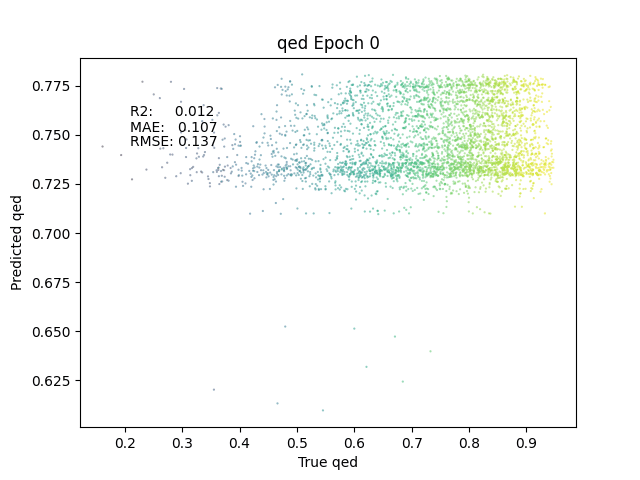

24
Error loading temp/sa Epoch 48.png: [Errno 2] No such file or directory: 'temp/sa Epoch 48.png'


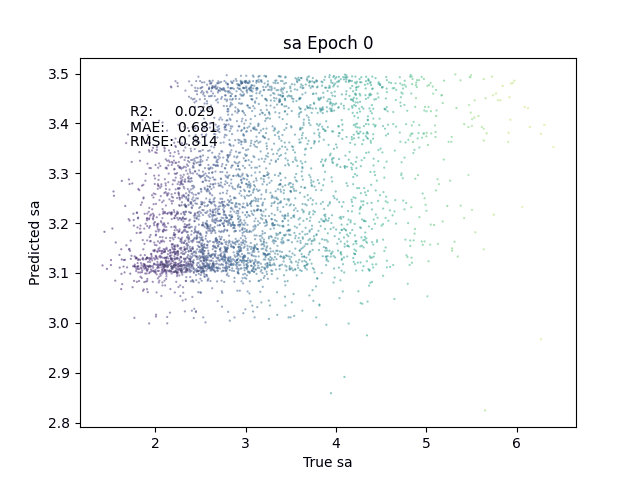

24


In [167]:
import imageio
from os import walk
from PIL import Image as PILImage
path = 'temp'

for name in  ['qed', 'sa']:
    images = []
    for i in range(1000):
        try:
            file_name = path + f'/{name} Epoch {i*2}.png'
            # print(file_name)
            img = PILImage.open(file_name)
            if img.mode == 'RGBA': img = img.convert('RGB')
            images.append(img)
        except Exception as e:
            print(f"Error loading {file_name}: {e}")
            break

    gif_path = f'{path}/gif_{name}.gif'
    imageio.mimsave(gif_path, images, duration=.00001)
    from IPython.display import Image
    gif_path = f'{path}/gif_{name}.gif'
    display(Image(data=open(gif_path,'rb').read(), format='png'))
